# Imports

In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
from glob import glob
from scipy.signal import butter, filtfilt
import seaborn as sns
from utils import *

# Load Data

In [2]:
sub_files = glob('/Users/camilla.strauss/Desktop/CUNY_Data/Data/*/*.xdf')

In [ ]:
sub_number = 3
xdf_path = sub_files[sub_number]
sub_id = xdf_path.split('/')[6].split('-')[1]
ps_df = import_physio_data(xdf_path) 
stim_df = import_stim_data(xdf_path)

In [6]:
rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp_df['time'] = rsp_df['lsl_time_stamp'] - rsp_df['lsl_time_stamp'][0]
rsp = rsp_df.respiration

srate = 1/(rsp_df.lsl_time_stamp.diff().median())


# Extract Peaks

In [8]:
# Clean signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'khodadad')

# Extract peaks
peaks_df, peaks_dict = nk.rsp_peaks(cleaned) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
fixed_peaks = nk.rsp_fixpeaks(peaks_dict)
formatted = nk.signal_formatpeaks(fixed_peaks, desired_length=len(cleaned),peak_indices=fixed_peaks["RSP_Peaks"]) # what is this for

# SNR

In [9]:
# get power by np.var() on signal
signal_power = np.var(cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = rsp - cleaned  # residual noise
noise_power = np.var(noise_signal)

snr = 10 * np.log10(signal_power / noise_power)
print(f'{snr:.3f}')

6.499


# Breath Amplitude

In [10]:
# get values (in Volts) of the troughs and peaks using cleaned data
cleaned_troughs_values = cleaned[peaks_df['RSP_Troughs'].to_numpy() == 1]
cleaned_peaks_values = cleaned[peaks_df['RSP_Peaks'].to_numpy() == 1]

In [11]:
#  values (in Volts) of the troughs and peaks using raw data
raw_peaks_values = rsp.to_numpy()[peaks_df['RSP_Peaks'].to_numpy() == 1]
raw_troughs_values = rsp.to_numpy()[peaks_df['RSP_Troughs'].to_numpy() == 1]

In [13]:
raw_breath_amplitude = raw_peaks_values-raw_troughs_values

print('raw breath amplitude stats')
print(f'mean = {np.nanmean(raw_breath_amplitude):.3f}')
print(f'std = {np.nanstd(raw_breath_amplitude):.3f}')
print(f'range = {np.nanmin(raw_breath_amplitude):.3f} - {np.nanmax(raw_breath_amplitude):.3f}')

raw breath amplitude stats
mean = 0.174
std = 0.221
range = 0.026 - 2.023


In [14]:
cleaned_breath_amplitude = cleaned_peaks_values - cleaned_troughs_values

print('cleaned breath amplitude stats')
print(f'mean = {np.mean(cleaned_breath_amplitude):.3f}')
print(f'std = {np.std(cleaned_breath_amplitude):.3f}')
print(f'range = {np.min(cleaned_breath_amplitude):.3f} - {np.max(cleaned_breath_amplitude):.3f}')

cleaned breath amplitude stats
mean = 0.170
std = 0.216
range = 0.026 - 2.001


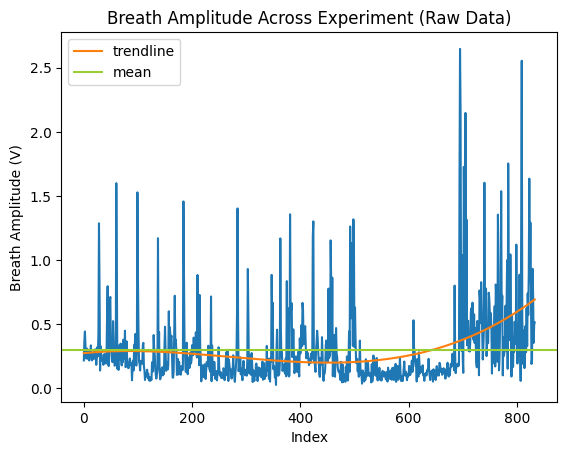

In [120]:
x = np.arange(len(raw_breath_amplitude))
y = raw_breath_amplitude
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
plt.plot(x, y)
plt.plot(x, p(x), label = 'trendline')
plt.axhline(np.mean(raw_breath_amplitude), color = 'yellowgreen', label = 'mean')
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Index')
plt.title('Breath Amplitude Across Experiment (Raw Data)')

plt.legend()
plt.show()

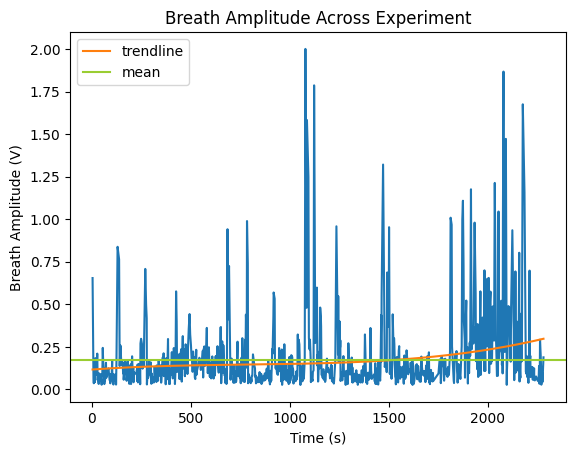

In [17]:
# using cleaned data
x = rsp_df.time[peaks_df['RSP_Peaks'].to_numpy() == 1]
y = cleaned_breath_amplitude
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
plt.plot(x, y)
plt.plot(x, p(x), label = 'trendline')
plt.axhline(np.mean(cleaned_breath_amplitude), color = 'yellowgreen', label = 'mean')
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Time (s)')
plt.title('Breath Amplitude Across Experiment')
plt.legend()

plt.savefig(f'report_images/{sub_id}_rsp_breathamplitude.png')
plt.show()

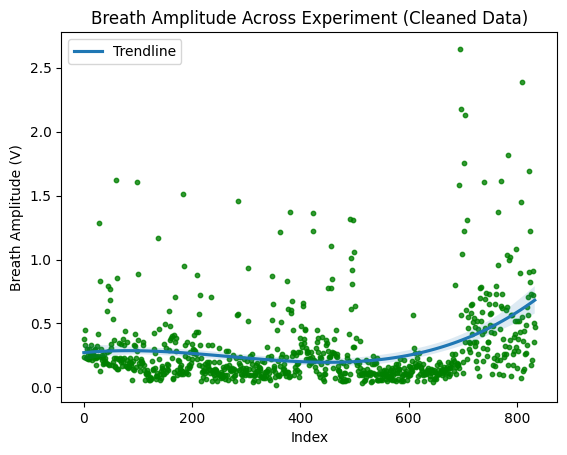

In [94]:
sns.regplot(x = x, y = y, order = 3, ci = 95, scatter_kws={'s': 10, 'color': 'g'}, line_kws = {'label': 'Trendline'})
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Index')
plt.title('Breath Amplitude Across Experiment (Cleaned Data)')
plt.legend()
plt.show()

# Respiration Rate

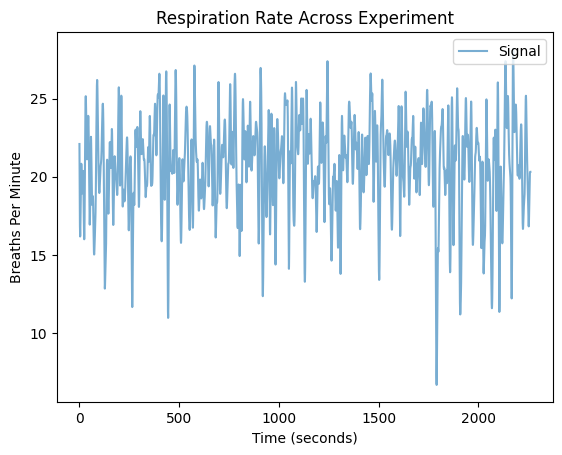

In [18]:
# Extract rate
rsp_rate = nk.rsp_rate(cleaned, peaks_dict, sampling_rate=srate, method = 'xcorr')
# Visualize
nk.signal_plot(rsp_rate, sampling_rate=srate, alpha = 0.6)
plt.ylabel('Breaths Per Minute')
plt.title('Respiration Rate Across Experiment')
plt.savefig(f'report_images/{sub_id}_rsp_respirationrate.png')
plt.show()

In [19]:
print(f'respiration rate mean:  {np.mean(rsp_rate):.3f}')
print(f'respiration rate std:  {np.std(rsp_rate):.3f}')
print(f'respiration rate range:  {np.min(rsp_rate):.3f} - {np.max(rsp_rate):.3f}')

respiration rate mean:  20.781
respiration rate std:  2.937
respiration rate range:  6.682 - 28.176


# Plot Raw Data for Different Experiment Sections

In [ ]:
# get data for experiment sections
rsp_resting_state = get_event_data('RestingState', rsp_df, stim_df)
rsp_story_listening = get_event_data('StoryListening', rsp_df, stim_df)

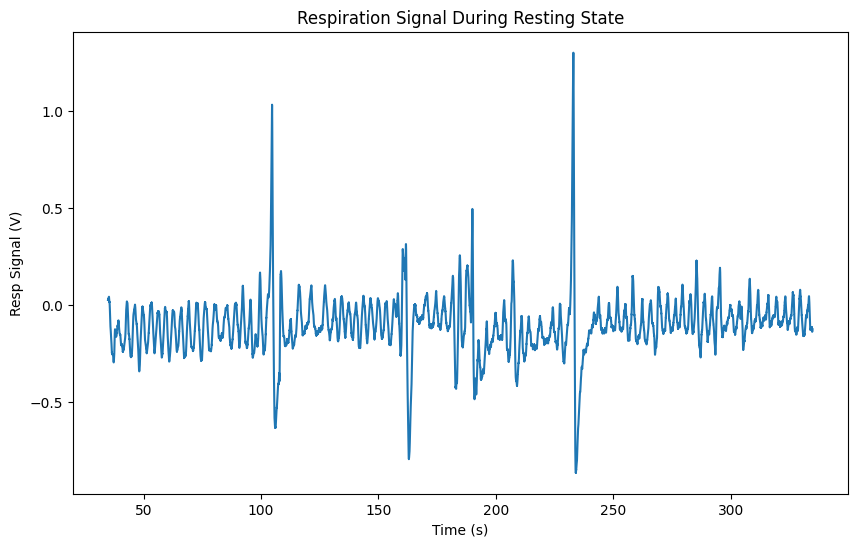

In [ ]:
plt.plot(rsp_resting_state.time, rsp_resting_state.respiration)
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.title("Respiration Signal During Resting State")
plt.show()

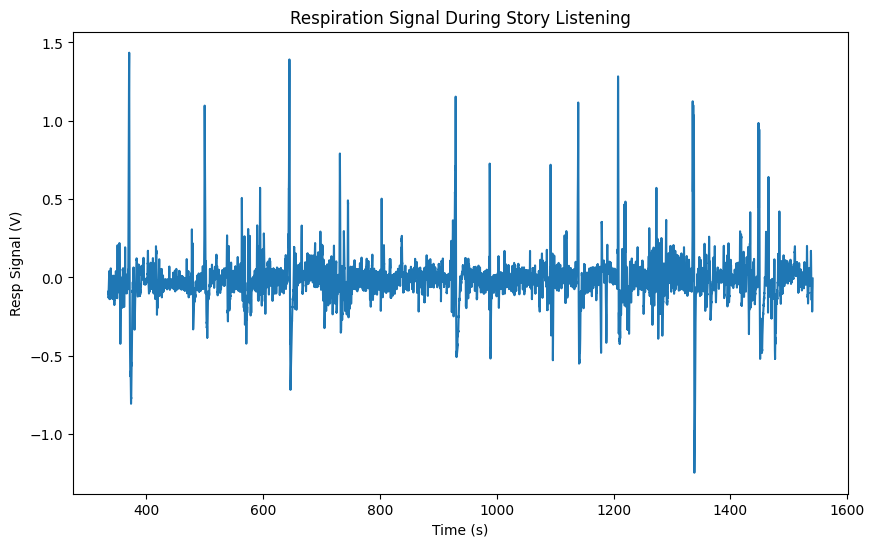

In [ ]:
plt.plot(rsp_story_listening.time, rsp_story_listening.respiration)
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.title("Respiration Signal During Story Listening")
plt.show()

In [61]:
# get list of stories in order 
stories_df = pd.DataFrame(columns = ['name', 'lsl_time_stamp'])
story_onsets = [20, 30, 40, 50, 60, 70]
for i in story_onsets:
    stories_df.loc[i, 'name'] = events[i].split('_')[1]
    stories_df.loc[i, 'lsl_time_stamp'] = stim_df.loc[stim_df.event == events[i], 'lsl_time_stamp'].values[0]

stories_df.sort_values(by = 'lsl_time_stamp', inplace = True)
stories = (stories_df.name).tolist()
stories

['BirthdayParty',
 'ZoomClass',
 'Tornado',
 'FrogDissection',
 'DanceContest',
 'CampFriend']

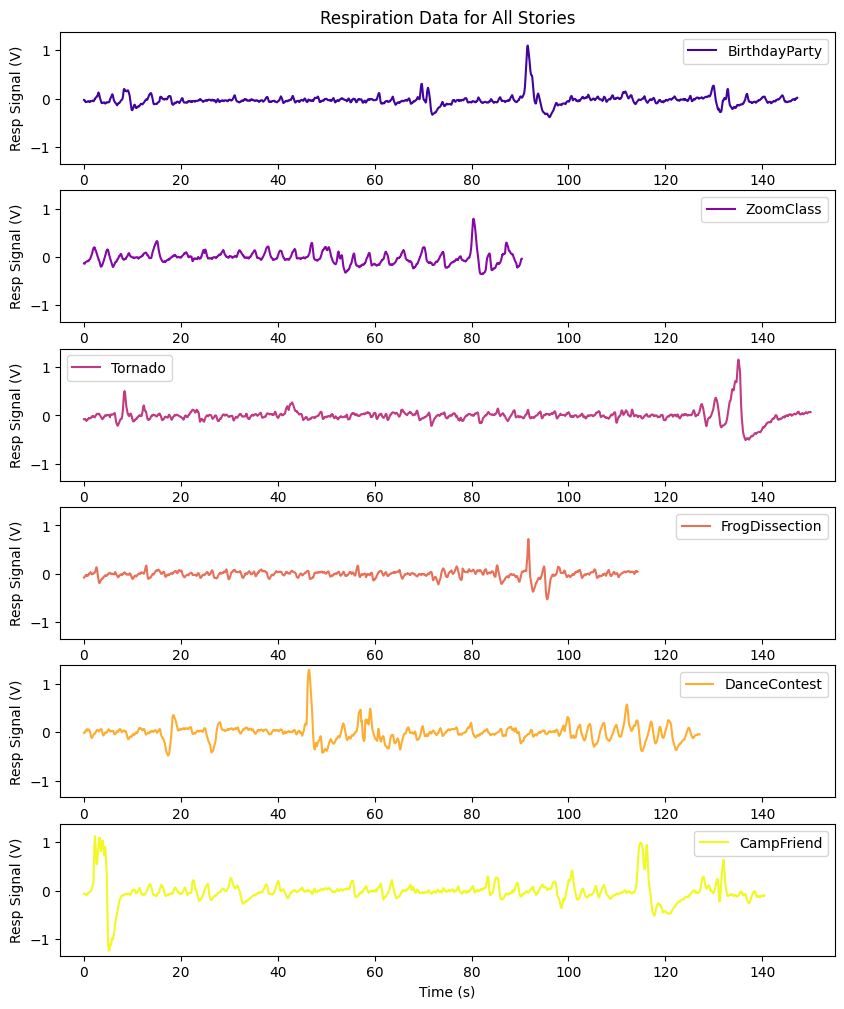

In [66]:
colors = plt.cm.plasma(np.linspace(.1, 1, len(stories)))
fig, ax = plt.subplots(figsize=(10,12), nrows=len(stories), ncols=1)
max_x = 0
max_y = 0
min_y = 0

for i, story in enumerate(stories): 
    # make df for current story
    rsp_story = get_event_data(story, rsp_df, stim_df).reset_index()
    rsp_story['time'] = rsp_story.lsl_time_stamp - rsp_story.lsl_time_stamp[0]


    # get x + y min and max for all stories
    current_maxx = rsp_story['time'].max()
    current_maxy = rsp_story['respiration'].max()
    current_miny = rsp_story['respiration'].min()
    if current_maxx > max_x:
        max_x = current_maxx
    if current_maxy > max_y:
        max_y = current_maxy
    if current_miny < min_y:
        min_y = current_miny

    # plot
    ax[i].plot(rsp_story.time, rsp_story.respiration, label = story, color = colors[i])
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Resp Signal (V)")
    ax[i].legend()

# set axis to be the same
for axis in ax:
    axis.set_xlim([-5, max_x + 5])
    axis.set_ylim([min_y-0.1, max_y+0.1])


ax[0].set_title("Respiration Data for All Stories")
plt.show()


# Peak to Peak interval

In [56]:
# get all rows of rsp_df where peaks_df = 1
ptp_df = rsp_df[peaks_df['RSP_Peaks'].to_numpy() == 1]
ptp_df.reset_index(drop = True, inplace = True)
ptp_df.loc[:,'time'] = ptp_df.lsl_time_stamp - ptp_df.lsl_time_stamp[0]
ptp = ptp_df.lsl_time_stamp.diff()


In [21]:
print(f'peak to peak interval stats \n\
mean: {np.nanmean(ptp):.3f} \n\
std: {np.nanstd(ptp):.3f} \n\
range: {np.nanmin(ptp):.3f} - {np.nanmax(ptp):.3f}')

peak to peak interval stats 
mean: 2.366 
std: 1.540 
range: 0.486 - 25.796


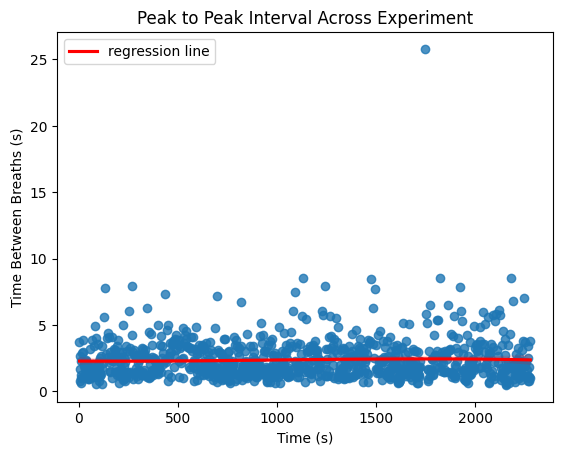

In [58]:
sns.regplot(x = ptp_df.time, y = ptp.to_numpy(), order = 3, line_kws = {'color': 'r', 'label': 'regression line'}, ci = 95)
plt.ylabel('Time Between Breaths (s)')
plt.xlabel('Time (s)')
plt.title('Peak to Peak Interval Across Experiment')
plt.legend()
plt.show()

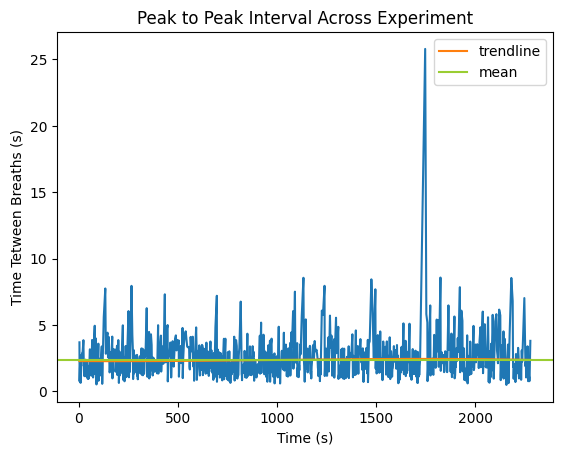

In [57]:
x = ptp_df['time'][1:]
y = ptp[1:]
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
plt.plot(x, y)
plt.plot(x, p(x), label = 'trendline')
plt.axhline(np.nanmean(ptp), color = 'yellowgreen', label = 'mean')
plt.ylabel('Time Between Breaths (s)')
plt.xlabel('Time (s)')
plt.title('Peak to Peak Interval Across Experiment')

plt.legend()
plt.savefig(f'report_images/{sub_id}_rsp_peaktopeak.png')
plt.show()

# Baseline Drift Using Lowpass Filter

In [60]:
# standard dev of low pass filter- long term drift estimation 
def lowpass_filter(data, cutoff=0.05, fs=500, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
lowpass = lowpass_filter(rsp)
print('{:.3f}'.format(np.std(lowpass)))

0.057


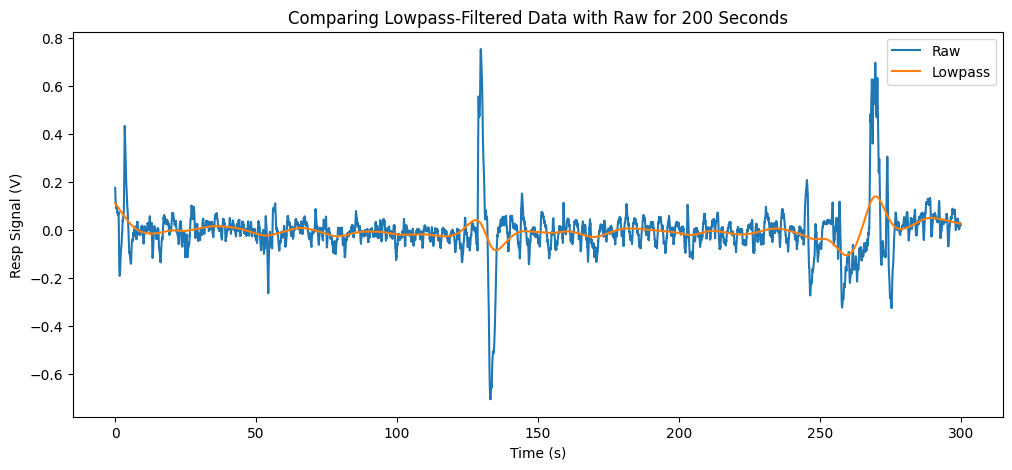

In [63]:
plt.figure(figsize = (12, 5))
plt.plot(rsp_df.time[:150000], rsp[:150000], label = "Raw")
plt.plot(rsp_df.time[:150000], lowpass[:150000], label = "Lowpass")
plt.title("Comparing Lowpass-Filtered Data with Raw for 200 Seconds")
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.legend()
plt.show()

# Autocorrelation

### Autocorrelation at median breath cycle

In [64]:
# median time between breaths
median_breath_period = np.nanmedian(ptp)  # Typical breathing period
# lag = number of samples between each breath
lag = int(median_breath_period * srate)

In [65]:
autocorr = rsp.autocorr(lag = lag)
print(f"Autocorrelation at typical breath cycle: {autocorr:.4f}")

Autocorrelation at typical breath cycle: 0.1145


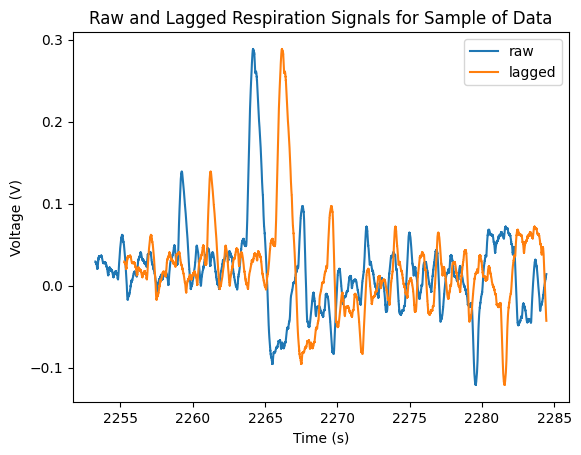

In [83]:
# visualize raw signal with lag 
plt.plot(rsp_df.time[1115000:], rsp[1115000:], label = 'raw')
plt.plot(rsp_df.time[1115000+lag:], rsp[1115000:-lag], label = 'lagged')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Raw and Lagged Respiration Signals for Sample of Data')
plt.legend()
plt.show()

### Autocorrelation at all possible lags

In [84]:
autocorr2 = np.correlate(rsp, rsp, mode='full')

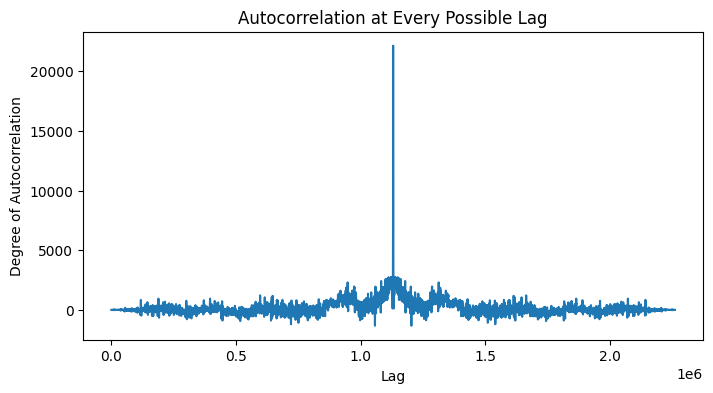

In [85]:
# rename the plot later
plt.figure(figsize = (8,4))
plt.plot(autocorr2)
plt.title("Autocorrelation at Every Possible Lag")
plt.ylabel("Degree of Autocorrelation")
plt.xlabel("Lag")
plt.savefig(f'report_images/{sub_id}_rsp_autocorrelation.png')
plt.show()

# Reported Metrics

In [87]:
print(f'effective sampling rate: {srate:.4f}')

print('breath amplitude stats')
print(f'mean = {np.mean(cleaned_breath_amplitude):.3f}')
print(f'std = {np.std(cleaned_breath_amplitude):.3f}')
print(f'range = {np.min(cleaned_breath_amplitude):.3f} - {np.max(cleaned_breath_amplitude):.3f}')

print(f'respiration rate mean:  {np.mean(rsp_rate):.3f}')
print(f'respiration rate std:  {np.std(rsp_rate):.3f}')
print(f'respiration rate range:  {np.min(rsp_rate):.3f} - {np.max(rsp_rate):.3f}')

print(f'peak to peak interval stats \n\
mean: {np.nanmean(ptp):.3f} \n\
std: {np.nanstd(ptp):.3f} \n\
range: {np.nanmin(ptp):.3f} - {np.nanmax(ptp):.3f}')

print('baseline drift: {:.3f}'.format(np.std(lowpass)))


print(f"Autocorrelation at typical breath cycle: {autocorr:.4f}")


effective sampling rate: 500.0620
breath amplitude stats
mean = 0.170
std = 0.216
range = 0.026 - 2.001
respiration rate mean:  20.781
respiration rate std:  2.937
respiration rate range:  6.682 - 28.176
peak to peak interval stats 
mean: 2.366 
std: 1.540 
range: 0.486 - 25.796
baseline drift: 0.057
Autocorrelation at typical breath cycle: 0.1145
